# <center>Лабораторная работа №8
## <center>Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD).

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [лекции](https://nbviewer.jupyter.org/github/soolstafir/Machine-learning-course/blob/master/Lections/ml_lection08_sgd_hashing_vowpal_wabbit/ml_lection08_sgd_hashing_vowpal_wabbit.ipynb) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    
    def __init__(self, eta=1e-3, n_iter=10):
        
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
    
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X.shape[1])
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]  
                w = new_w.copy()
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))      
        self.w_ = self.weights_[np.argmin(self.mse_)]     
        return self
                  
    def predict(self, X):
        
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        return X.dot(self.w_)    

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [4]:
data_demo = pd.read_csv('weights_heights.csv')

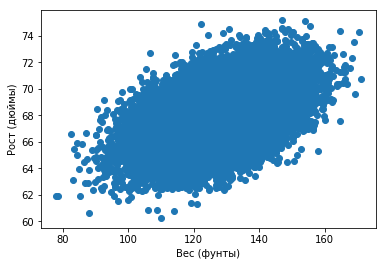

In [5]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [6]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [9]:
sgdr = SGDRegressor()
sgdr.fit(X_train_scaled, y_train)

100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


SGDRegressor(eta=0.001, n_iter=10)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

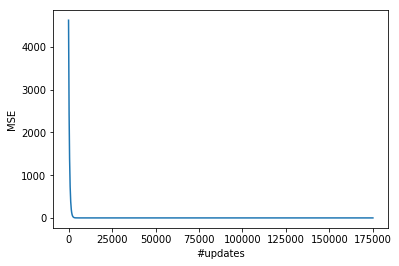

In [9]:
plt.plot(range(len(sgdr.mse_)), sgdr.mse_)
plt.xlabel('#updates')
plt.ylabel('MSE');

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [10]:
np.min(sgdr.mse_), sgdr.w_

(2.7151352406643627, array([67.9898497 ,  0.94447605]))

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

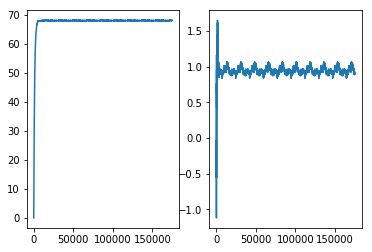

In [11]:
plt.subplot(121)
plt.plot(range(len(sgdr.weights_)), 
         [w[0] for w in sgdr.weights_]);
plt.subplot(122)
plt.plot(range(len(sgdr.weights_)), 
         [w[1] for w in sgdr.weights_]);

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [12]:
sgdr_holdout_mse = mean_squared_error(y_valid, sgdr.predict(X_valid_scaled))
sgdr_holdout_mse

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [10]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid, lm.predict(X_valid_scaled))
linreg_holdout_mse
#5


[0.94537278] 67.98930834742858


2.670830767667635

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [11]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [125]:
class SGDClassifier(BaseEstimator):
    
    def __init__ (self, C, eta = 1e-3, n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        self.loss_ = []
        self.weights_ =[]

        
    def fit (self, X, y):
        #столбец из единиц
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        #нули
        w = np.zeros(X.shape[1])
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):        
                new_w = w.copy()
                new_w[0] += self.eta * (self.C * y[i] * sigma(y[i] * w.dot(X[i, :])))
                for j in range(1, X.shape[1]):
                    if j != 0: 
                        brokener = 1
                    else: brokener = 0 
                    new_w[j] += self.eta * (self.C * y[i] * X[i, j] * sigma(y[i] * w.dot(X[i, :])) + brokener)
                w = new_w.copy()
                
                self.weights_.append(w)
                self.loss_.append(log_loss(y, X.dot(w)))       
        self.w_ = self.weights_[np.argmin(self.loss_)]    
        return self
        
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        return X.dot(self.w_)           
                                
    def predict(self, X):
        predict = []
        x = self.predict_proba(X)
        for i in x:
            if i < 0.5:
                predict.append(1)
            else: predict.append(-1)
        self.predictions = np.array(predict)
        return self.predictions
                 

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [21]:
from sklearn.datasets import load_breast_cancer

In [22]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [126]:
sgdc = SGDClassifier(C=1, n_iter = 3, eta=1e-3)
sgdc.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

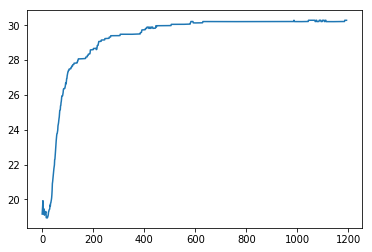

In [78]:
plt.subplot(111)
plt.plot(range(len(sgdc.loss_)), 
         [l for l in sgdc.loss_]);

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [130]:
sgdc = SGDClassifier(C=1000, n_iter = 10, eta=1e-3)
sgdc.fit(X_train_scaled, y_train)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


SGDClassifier(C=1000, eta=0.001, n_iter=10)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

In [131]:
sgdc.w_

array([-1.47875732, -4.30371072, -6.39869814, -4.38043678, -4.47913479,
       -1.62019392, -2.8099159 , -4.53818408, -5.30676148, -3.6715095 ,
        1.41619344, -4.15380477, -0.5670244 , -4.09115119, -3.61550624,
       -0.26185951, -1.4893861 , -1.07950589, -2.90769604, -1.53850072,
       -0.0407275 , -4.57788251, -5.3734554 , -4.68390789, -4.71128663,
       -3.33351906, -3.60292374, -3.79560106, -4.4363318 , -3.53457829,
       -1.80857076])

In [134]:
len(sgdc.w_)

31

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [132]:
sgdc_holdout_log = log_loss(y_valid, sgdc.predict(X_valid_scaled))
sgdc_holdout_log 

32.11527849730514

In [133]:
roc_auc_score(y_valid, sgdc.predict(X_valid_scaled))

0.061847988077496294

In [87]:
from sklearn.linear_model import LogisticRegression
Log_reg = LogisticRegression(random_state=17)
Log_reg.fit(X_train_scaled, y_train)
log_holdout_log = log_loss(y_valid, Log_reg.predict(X_valid_scaled))
log_holdout_log

/home/anatolii/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8079432980664542

In [90]:
roc_auc_score(y_valid, Log_reg.predict(X_valid_scaled))

0.9672131147540984

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [4]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [5]:
# поменяйте путь к файлу
reviews_train = load_files("imdb_reviews/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [6]:
reviews_test = load_files("imdb_reviews/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [14]:
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)


((25000, 1513832), (25000, 1513832))

In [15]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [17]:
%%time
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)


CPU times: user 3min 9s, sys: 9.22 s, total: 3min 18s
Wall time: 49.8 s


In [21]:
roc_auc_score(y_test, lr.predict(X_test))

0.8962799999999999

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [43]:
%%time
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', max_iter=100, tol = 1e-3, random_state=17)
clf.fit(X_train, y_train)
## 2,3,4,7

CPU times: user 2.32 s, sys: 83.7 ms, total: 2.4 s
Wall time: 1.73 s


In [44]:
roc_auc_score(y_test, clf.predict(X_test))
#2

0.88872

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5